In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pip install transformers
!pip install datasets
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 8.4 MB/s 
     |████████████████████████████████| 6.6 MB 42.8 MB/s 
     |████████████████████████████████| 120 kB 63.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 9.8 MB/s 
     |████████████████████████████████| 212 kB 57.0 MB/s 
     |████████████████████████████████| 115 kB 43.0 MB/s 
     |████████████████████████████████| 127 kB 52.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 7.9 MB/s 


In [3]:
!nvidia-smi

Thu Sep 22 02:47:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import os
import gc
import math
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
from tqdm import tqdm
import re
import html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam, SGD, AdamW, RAdam
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import StratifiedKFold,StratifiedGroupKFold,GroupKFold
from sklearn.metrics import log_loss,f1_score

from transformers import AutoModel, AutoConfig, AutoTokenizer, AdamW, DataCollatorWithPadding
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [5]:
DIR = '/content/drive/MyDrive/Competitions/Signate/MUFJ'
INPUT_DIR = os.path.join(DIR,'input')
OUTPUT_DIR = os.path.join(DIR,'output')
OUTPUT_SUB_DIR = os.path.join(OUTPUT_DIR,'submission')
#OUTPUT_MODEL_DIR = os.path.join(OUTPUT_DIR,'model')
OUTPUT_MODEL_DIR19 = DIR + '/output/model/EXP19/'
OUTPUT_MODEL_DIR20 = DIR + '/output/model/EXP20/'
OUTPUT_MODEL_DIR22 = DIR + '/output/model/EXP22/'
OUTPUT_MODEL_DIR23 = DIR + '/output/model/EXP23/'
OUTPUT_MODEL_DIR24 = DIR + '/output/model/EXP24/'
OUTPUT_MODEL_DIR25 = DIR + '/output/model/EXP25/'
OUTPUT_MODEL_DIR27 = DIR + '/output/model/EXP27/'
OUTPUT_MODEL_DIR28 = DIR + '/output/model/EXP28/'
OUTPUT_MODEL_DIR31 = DIR + '/output/model/EXP31/'
OUTPUT_MODEL_DIR41 = DIR + '/output/model/EXP41/'
OUTPUT_MODEL_DIR42 = DIR + '/output/model/EXP42/'

OUTPUT_MODEL_DIR21 = DIR + '/output/model/EXP21/'
OUTPUT_MODEL_DIR43 = DIR + '/output/model/EXP43/'
OUTPUT_MODEL_DIR44 = DIR + '/output/model/EXP44/'
OUTPUT_MODEL_DIR45 = DIR + '/output/model/EXP45/'
OUTPUT_MODEL_DIR46 = DIR + '/output/model/EXP46/'

OUTPUT_MODEL_DIR34 = DIR + '/output/model/EXP34/'
OUTPUT_MODEL_DIR39 = DIR + '/output/model/EXP39/'
OUTPUT_MODEL_DIR40 = DIR + '/output/model/EXP40/'
OUTPUT_MODEL_DIR47 = DIR + '/output/model/EXP47/'
OUTPUT_MODEL_DIR48 = DIR + '/output/model/EXP48/'

In [6]:
class CFG19:
    num_workers=4
    path=OUTPUT_MODEL_DIR19
    config_path=path+'config.pth'
    model="microsoft/deberta-v3-base"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=256
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=True
    freezing=True
    clean_content = True
    target2col = False

class CFG20:
    num_workers=4
    path=OUTPUT_MODEL_DIR20
    config_path=path+'config.pth'
    model="microsoft/deberta-v3-large"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=256
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=True
    freezing=True
    clean_content = True
    target2col = False

class CFG22:
    num_workers=4
    path=OUTPUT_MODEL_DIR22
    config_path=path+'config.pth'
    model="facebook/bart-large"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=128
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=False
    freezing=False
    clean_content = True
    target2col = False

class CFG23:
    num_workers=4
    path=OUTPUT_MODEL_DIR23
    config_path=path+'config.pth'
    model="microsoft/deberta-large"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=256
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=True
    freezing=True
    clean_content = True
    target2col = False

class CFG24:
    num_workers=4
    path=OUTPUT_MODEL_DIR24
    config_path=path+'config.pth'
    model="funnel-transformer/large"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=256
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=False
    freezing=False
    clean_content = True
    target2col = False

class CFG25:
    num_workers=4
    path=OUTPUT_MODEL_DIR25
    config_path=path+'config.pth'
    model="xlnet-large-cased"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=128
    seed=42
    n_fold=4
    trn_fold=[1, 2, 3]
    gradient_checkpointing=False
    freezing=False
    clean_content = True
    target2col = False

class CFG27:
    num_workers=4
    path=OUTPUT_MODEL_DIR27
    config_path=path+'config.pth'
    model="microsoft/deberta-xlarge"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=256
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=True
    freezing=True
    clean_content = True
    target2col = False

class CFG28:
    num_workers=4
    path=OUTPUT_MODEL_DIR28
    config_path=path+'config.pth'
    model="microsoft/deberta-base"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=256
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=True
    freezing=True
    clean_content = True
    target2col = False

class CFG31:
    num_workers=4
    path=OUTPUT_MODEL_DIR31
    config_path=path+'config.pth'
    model="funnel-transformer/medium"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=256
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=False
    freezing=False
    clean_content = True
    target2col = False

class CFG41:
    num_workers=4
    path=OUTPUT_MODEL_DIR41
    config_path=path+'config.pth'
    model="facebook/bart-base"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=256
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=False
    freezing=False
    clean_content = True
    target2col = False

class CFG42:
    num_workers=4
    path=OUTPUT_MODEL_DIR42
    config_path=path+'config.pth'
    model="facebook/bart-large-mnli"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=180
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=False
    freezing=False
    clean_content = True
    target2col = False


class CFG21:
    num_workers=4
    path=OUTPUT_MODEL_DIR21
    config_path=path+'config.pth'
    model="microsoft/deberta-v3-base"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=256
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=True
    freezing=True
    clean_content = True
    target2col = False

class CFG43:
    num_workers=4
    path=OUTPUT_MODEL_DIR43
    config_path=path+'config.pth'
    model="funnel-transformer/large"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=256
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=False
    freezing=False
    clean_content = False
    target2col = False

class CFG44:
    num_workers=4
    path=OUTPUT_MODEL_DIR44
    config_path=path+'config.pth'
    model="microsoft/deberta-v3-large"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=256
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=False
    freezing=True
    clean_content = True
    target2col = False

class CFG45:
    num_workers=4
    path=OUTPUT_MODEL_DIR45
    config_path=path+'config.pth'
    model="facebook/bart-large-mnli"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=180
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=False
    freezing=False
    clean_content = False
    target2col = False

class CFG46:
    num_workers=4
    path=OUTPUT_MODEL_DIR46
    config_path=path+'config.pth'
    model="microsoft/deberta-base"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=256
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=True
    freezing=True
    clean_content = True
    target2col = False


class CFG34:
    num_workers=4
    path=OUTPUT_MODEL_DIR34
    config_path=path+'config.pth'
    model="microsoft/deberta-v3-base"
    batch_size=32
    fc_dropout=0.2
    target_size=2
    max_len=256
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=True
    freezing=True
    clean_content = True
    target_cols = ["state","category1"]
    target2col = True

class CFG39:
    num_workers=4
    path=OUTPUT_MODEL_DIR39
    config_path=path+'config.pth'
    model="microsoft/deberta-v3-large"
    batch_size=32
    fc_dropout=0.2
    target_size=2
    max_len=256
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=True
    freezing=True
    clean_content = True
    target_cols = ["state","category1"]
    target2col = True

class CFG40:
    num_workers=4
    path=OUTPUT_MODEL_DIR40
    config_path=path+'config.pth'
    model="microsoft/deberta-xlarge"
    batch_size=32
    fc_dropout=0.2
    target_size=2
    max_len=256
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=True
    freezing=True
    clean_content = True
    target_cols = ["state","category1"]
    target2col = True

class CFG47:
    num_workers=4
    path=OUTPUT_MODEL_DIR47
    config_path=path+'config.pth'
    model="funnel-transformer/large"
    batch_size=32
    fc_dropout=0.2
    target_size=2
    max_len=256
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=False
    freezing=False
    clean_content = True
    target_cols = ["state","category1"]
    target2col = True

class CFG48:
    num_workers=4
    path=OUTPUT_MODEL_DIR48
    config_path=path+'config.pth'
    model="facebook/bart-large-mnli"
    batch_size=32
    fc_dropout=0.2
    target_size=2
    max_len=180
    seed=42
    n_fold=4
    trn_fold=[1, 2, 3]
    gradient_checkpointing=False
    freezing=False
    clean_content = True
    target_cols = ["state","category1"]
    target2col = True

In [7]:
def get_score(labels, outputs):
    thresh = 0.5
    y_pred = outputs
    y_true = labels
    return f1_score(y_true, (y_pred>thresh).astype(int))


def get_logger(filename=OUTPUT_DIR+'/infrence'):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=CFG25.seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=CFG25.seed)

In [8]:
def freeze(module):
    """
    Freezes module's parameters.
    """
    
    for parameter in module.parameters():
        parameter.requires_grad = False
        
def get_freezed_parameters(module):
    """
    Returns names of freezed parameters of the given module.
    """
    
    freezed_parameters = []
    for name, parameter in module.named_parameters():
        if not parameter.requires_grad:
            freezed_parameters.append(name)
            
    return freezed_parameters

def set_embedding_parameters_bits(embeddings_path, optim_bits=32):
    """
    https://github.com/huggingface/transformers/issues/14819#issuecomment-1003427930
    """
    
    embedding_types = ("word", "position", "token_type")
    for embedding_type in embedding_types:
        attr_name = f"{embedding_type}_embeddings"
        
        if hasattr(embeddings_path, attr_name): 
            bnb.optim.GlobalOptimManager.get_instance().register_module_override(
                getattr(embeddings_path, attr_name), 'weight', {'optim_bits': optim_bits}
            )

In [9]:
oof_19 = pd.read_pickle(CFG19.path+'oof_df.pkl')
oof_20 = pd.read_pickle(CFG20.path+'oof_df.pkl')
oof_22 = pd.read_pickle(CFG22.path+'oof_df.pkl')
oof_23 = pd.read_pickle(CFG23.path+'oof_df.pkl')
oof_24 = pd.read_pickle(CFG24.path+'oof_df.pkl')
oof_25 = pd.read_pickle(CFG25.path+'oof_df.pkl')
oof_27 = pd.read_pickle(CFG27.path+'oof_df.pkl')
oof_28 = pd.read_pickle(CFG28.path+'oof_df.pkl')
oof_31 = pd.read_pickle(CFG31.path+'oof_df.pkl')
oof_41 = pd.read_pickle(CFG41.path+'oof_df.pkl')
oof_42 = pd.read_pickle(CFG42.path+'oof_df.pkl')

oof_21 = pd.read_pickle(CFG21.path+'oof_df.pkl')
oof_43 = pd.read_pickle(CFG43.path+'oof_df.pkl')
oof_44 = pd.read_pickle(CFG44.path+'oof_df.pkl')
oof_45 = pd.read_pickle(CFG45.path+'oof_df.pkl')
oof_46 = pd.read_pickle(CFG46.path+'oof_df.pkl')

oof_34 = pd.read_pickle(CFG34.path+'oof_df.pkl')
oof_39 = pd.read_pickle(CFG39.path+'oof_df.pkl')
oof_40 = pd.read_pickle(CFG40.path+'oof_df.pkl')
oof_47 = pd.read_pickle(CFG47.path+'oof_df.pkl')
oof_48 = pd.read_pickle(CFG48.path+'oof_df.pkl')

In [10]:
labels = oof_25['state'].values

preds_19 = oof_19['pred'].values
preds_20 = oof_20['pred'].values
preds_22 = oof_22['pred'].values
preds_23 = oof_23['pred'].values
preds_24 = oof_24['pred'].values
preds_25 = oof_25['pred'].values
preds_27 = oof_27['pred'].values
preds_28 = oof_28['pred'].values
preds_31 = oof_31['pred'].values
preds_41 = oof_41['pred'].values
preds_42 = oof_42['pred'].values

preds_21 = oof_21['pred'].values
preds_43 = oof_43['pred'].values
preds_44 = oof_44['pred'].values
preds_45 = oof_45['pred'].values
preds_46 = oof_46['pred'].values

preds_34 = oof_34["pred_state"].values
preds_39 = oof_39["pred_state"].values
preds_40 = oof_40["pred_state"].values
preds_47 = oof_47["pred_state"].values
preds_48 = oof_48["pred_state"].values

preds_all = preds_19*0.06470878 + preds_20*0.0131939 + preds_22*0.06180668 +preds_23*0.05055884 + preds_24*0.02008916 + preds_25*0.06263664 + preds_27*0.08175019 + preds_28*0.03084266 + preds_31*0.03858474 + preds_41*0.02707047 + preds_42*0.08370543 + preds_21*0.07534494 + preds_43*0.08425437 + preds_44*0.07985377 + preds_45*0.08337871 + preds_46*0.01404711 + preds_34*0.02728774 + preds_39*0.00701513 + preds_40*0.03316138 + preds_47*0.02549253 + preds_48*0.03521683


preds1 = (preds_25+preds_28) / 2  #0.8071
preds2 = (preds_22+preds_23+preds_24+preds_31+preds1+preds_41) / 6  #0.8228
preds3 = (preds_19+preds_20+preds_27+preds_42) / 4  #0.8240

preds4 = preds_21*.35+preds_43*.35+preds_46*.3   #0.8213
preds5 = (preds_45+preds_44) / 2

preds6 = (preds_40+preds_47+preds_48) / 3  #0.8213  #0.8215
preds7 = preds_34*.5+preds_39*.5  #0.8207

preds_com = preds2*0.04754912 + preds3*0.04911001 + preds4*0.37500948 + preds5*0.37216546 + preds6*0.01848971 + preds7*0.13767623


preds_805 = preds_19*0.03209519 + preds_20*0.00845168 + preds_22*0.12410198 + preds_23*0.00022835 + preds_24*0.05227489 + preds_27*0.10028456 + preds_31*0.00259968 + preds_42*0.01994933 + preds_21*0.11993072 + preds_43*0.0957319 + preds_44*0.09343536 + preds_45*0.11866233 + preds_34*0.05481453 + preds_39*0.05538527 + preds_40*0.10995686 + preds_47*0.0027024 + preds_48*0.00939497

preds_810 = preds_19*0.03682987 + preds_20*0.0061083 + preds_27*0.11077566 + preds_42*0.10054404 + preds_44*0.16015766 + preds_45*0.03514027 + preds_34*0.12992343 + preds_39*0.15352078 + preds_40*0.12774139 + preds_48*0.13925859

score1 = get_score(labels, preds_all)
score2 = get_score(labels, preds_com)
score3 = get_score(labels, preds_805)
score4 = get_score(labels, preds_810)
LOGGER.info(f'CV all Score: {score1:<.4f}')
LOGGER.info(f'CV combine Score: {score2:<.4f}')
LOGGER.info(f'CV oof>.805 Score: {score3:<.4f}')
LOGGER.info(f'CV oof>.810 Score: {score4:<.4f}')

CV all Score: 0.8320
INFO:__main__:CV all Score: 0.8320
CV combine Score: 0.8311
INFO:__main__:CV combine Score: 0.8311
CV oof>.805 Score: 0.8310
INFO:__main__:CV oof>.805 Score: 0.8310
CV oof>.810 Score: 0.8315
INFO:__main__:CV oof>.810 Score: 0.8315


In [11]:
best_score_all = 0
best_thresh_all = 0.5
y_pred_all = preds_all
y_true = labels
for thresh in np.arange(0.2, 0.801, 0.01):
    thresh = np.round(thresh, 2)
    score = f1_score(y_true, (y_pred_all>thresh).astype(int))
    #print("F1 score at threshold {0} is {1}".format(thresh, score))
    if score > best_score_all:
        best_score_all = score
        best_thresh_all = thresh
print("All Pred best F1 score at threshold {0} is {1}".format(best_thresh_all, f1_score(y_true, (y_pred_all>best_thresh_all).astype(int))))

All Pred best F1 score at threshold 0.5 is 0.8319967923015238


In [12]:
best_score_com = 0
best_thresh_com = 0.5
y_pred_com = preds_com
y_true = labels
for thresh in np.arange(0.2, 0.801, 0.01):
    thresh = np.round(thresh, 2)
    score = f1_score(y_true, (y_pred_com>thresh).astype(int))
    #print("F1 score at threshold {0} is {1}".format(thresh, score))
    if score > best_score_com:
        best_score_com = score
        best_thresh_com = thresh
print("Pred Combine best F1 score at threshold {0} is {1}".format(best_thresh_com, f1_score(y_true, (y_pred_com>best_thresh_com).astype(int))))

Pred Combine best F1 score at threshold 0.5 is 0.831077694235589


In [13]:
best_score_805 = 0
best_thresh_805 = 0.5
y_pred_805 = preds_805
y_true = labels
for thresh in np.arange(0.2, 0.801, 0.01):
    thresh = np.round(thresh, 2)
    score = f1_score(y_true, (y_pred_805>thresh).astype(int))
    #print("F1 score at threshold {0} is {1}".format(thresh, score))
    if score > best_score_805:
        best_score_805 = score
        best_thresh_805 = thresh
print("oof>0.805 Pred best F1 score at threshold {0} is {1}".format(best_thresh_805, f1_score(y_true, (y_pred_805>best_thresh_805).astype(int))))

oof>0.805 Pred best F1 score at threshold 0.5 is 0.8310099287935011


In [14]:
best_score_810 = 0
best_thresh_810 = 0.5
y_pred_810 = preds_810
y_true = labels
for thresh in np.arange(0.2, 0.801, 0.01):
    thresh = np.round(thresh, 2)
    score = f1_score(y_true, (y_pred_810>thresh).astype(int))
    #print("F1 score at threshold {0} is {1}".format(thresh, score))
    if score > best_score_810:
        best_score_810 = score
        best_thresh_810 = thresh
print("oof>0.805 Pred best F1 score at threshold {0} is {1}".format(best_thresh_810, f1_score(y_true, (y_pred_810>best_thresh_810).astype(int))))

oof>0.805 Pred best F1 score at threshold 0.5 is 0.8315239244069159


In [15]:
#best score: 0.8319967923015238
#best weight: [0.06470878 0.0131939  0.06180668 0.05055884 0.02008916 0.06263664
# 0.08175019 0.03084266 0.03858474 0.02707047 0.08370543 0.07534494
# 0.08425437 0.07985377 0.08337871 0.01404711 0.02728774 0.00701513
# 0.03316138 0.02549253 0.03521683]

#best score: 0.831077694235589
#best weight: [0.04754912 0.04911001 0.37500948 0.37216546 0.01848971 0.13767623]

# oof > 0.805
#best score: 0.8310099287935011
#best weight: [0.03209519 0.00845168 0.12410198 0.00022835 0.05227489 0.10028456
# 0.00259968 0.01994933 0.11993072 0.0957319  0.09343536 0.11866233
# 0.05481453 0.05538527 0.10995686 0.0027024  0.00939497]

# oof > 0.810
#best score: 0.8315239244069159
#best weight: [0.03682987 0.0061083  0.11077566 0.10054404 0.16015766 0.03514027
# 0.12992343 0.15352078 0.12774139 0.13925859]

In [16]:
test = pd.read_csv(os.path.join(INPUT_DIR,'test.csv'))
sub = pd.read_csv(os.path.join(INPUT_DIR,'sample_submit.csv'),header=None)
sub.columns = ['id','state']

In [17]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub('',text)

def remove_html(text):
    html=re.compile(r"<[^>]*?>")
    return html.sub('',text)

def cleaning(texts):
    clean_texts = []
    for text in texts:
        # htmlタグを削除
        text = remove_URL(text)
        text = remove_html(text)
        #アルファベット以外をスペースに置き換え
        #clean_punc = re.sub(r'[^a-zA-Z]', ' ', text)
        #改行削除
        #text = text.replace("\n","")
        clean_texts.append(text)
    return clean_texts

def get_goal_values(df):
  df["goal"].replace("100000+","100000-100000",inplace=True)
  _df = df["goal"].str.split('-').apply(pd.Series).astype(float)
  _df.columns = ["goal_max","goal_min"]
  df["goal_max"] = _df["goal_max"].astype(str)
  df["goal_min"] = _df["goal_min"].astype(str)
  df["goal_median"] = _df[["goal_max","goal_min"]].median(axis=1)
  df["goal_median"] = df["goal_median"].astype(int)
  return df

if CFG25.clean_content==True:
    test['html_content'] = test['html_content'].map(lambda x: str(x))
    test['html_content'] = test['html_content'].apply(html.unescape)
    p = re.compile(r"<[^>]*?>|&amp;|[/'’\"”]")
    test['html_content'] = test['html_content'].map(lambda x: p.sub("", x))
    test['html_content'] = test['html_content'].map(lambda x: x.lstrip())
    test['html_content'] = test['html_content'].fillna('missing')

test = get_goal_values(test)
test['inputs1'] = test.goal_median.astype(str) + ' [SEP] ' + test.duration.astype(str) + ' [SEP] ' + test.country + ' [SEP] ' + test.category1 + ' [SEP] ' + test.category2 + ' [SEP] ' + test.html_content
test['inputs2'] = test.goal_median.astype(str) + ' [SEP] ' + test.duration.astype(str) + ' [SEP] ' + test.country + ' [SEP] ' + test.category2 + ' [SEP] ' + test.html_content

In [18]:
# ====================================================
# tokenizer
# ====================================================
CFG19.tokenizer = AutoTokenizer.from_pretrained(CFG19.path+'tokenizer/')
CFG20.tokenizer = AutoTokenizer.from_pretrained(CFG20.path+'tokenizer/')
CFG22.tokenizer = AutoTokenizer.from_pretrained(CFG22.path+'tokenizer/')
CFG23.tokenizer = AutoTokenizer.from_pretrained(CFG23.path+'tokenizer/')
CFG24.tokenizer = AutoTokenizer.from_pretrained(CFG24.path+'tokenizer/')
CFG25.tokenizer = AutoTokenizer.from_pretrained(CFG25.path+'tokenizer/')
CFG27.tokenizer = AutoTokenizer.from_pretrained(CFG27.path+'tokenizer/')
CFG28.tokenizer = AutoTokenizer.from_pretrained(CFG28.path+'tokenizer/')
CFG31.tokenizer = AutoTokenizer.from_pretrained(CFG31.path+'tokenizer/')
CFG41.tokenizer = AutoTokenizer.from_pretrained(CFG41.path+'tokenizer/')
CFG42.tokenizer = AutoTokenizer.from_pretrained(CFG42.path+'tokenizer/')

CFG21.tokenizer = AutoTokenizer.from_pretrained(CFG21.path+'tokenizer/')
CFG43.tokenizer = AutoTokenizer.from_pretrained(CFG43.path+'tokenizer/')
CFG44.tokenizer = AutoTokenizer.from_pretrained(CFG44.path+'tokenizer/')
CFG45.tokenizer = AutoTokenizer.from_pretrained(CFG45.path+'tokenizer/')
CFG46.tokenizer = AutoTokenizer.from_pretrained(CFG46.path+'tokenizer/')

CFG34.tokenizer = AutoTokenizer.from_pretrained(CFG34.path+'tokenizer/')
CFG39.tokenizer = AutoTokenizer.from_pretrained(CFG39.path+'tokenizer/')
CFG40.tokenizer = AutoTokenizer.from_pretrained(CFG40.path+'tokenizer/')
CFG47.tokenizer = AutoTokenizer.from_pretrained(CFG47.path+'tokenizer/')
CFG48.tokenizer = AutoTokenizer.from_pretrained(CFG48.path+'tokenizer/')

In [19]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False,
                           truncation=True)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TestDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        if cfg.target2col:
          self.inputs = df['inputs2'].values
        else:
          self.inputs = df['inputs1'].values

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.inputs[item])
        return inputs

In [20]:
# ====================================================
# Model
# ====================================================
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

class MaxPooling(nn.Module):
    def __init__(self):
        super(MaxPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        embeddings = last_hidden_state.clone()
        embeddings[input_mask_expanded == 0] = -1e4
        max_embeddings, _ = torch.max(embeddings, dim=1)
        return max_embeddings
    

class CustomModel1(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
            LOGGER.info(self.config)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        if self.cfg.gradient_checkpointing:
            self.model.gradient_checkpointing_enable()

        # Freezing
        if cfg.freezing:
            # freezing embeddings and first 2 layers of encoder
            freeze((self.model).embeddings)
            freeze((self.model).encoder.layer[:2])
            cfg.after_freezed_parameters = filter(lambda parameter: parameter.requires_grad, (self.model).parameters())

        self.pool = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, cfg.target_size)
        self._init_weights(self.fc)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        feature = self.pool(last_hidden_states, inputs['attention_mask'])
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(feature)
        return output


class CustomModel2(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
            LOGGER.info(self.config)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        if self.cfg.gradient_checkpointing:
            self.model.gradient_checkpointing_enable()

        # Freezing
        if cfg.freezing:
            # freezing embeddings and first 2 layers of encoder
            freeze((self.model).embeddings)
            freeze((self.model).encoder.layer[:2])
            cfg.after_freezed_parameters = filter(lambda parameter: parameter.requires_grad, (self.model).parameters())

        self.pool = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, cfg.target_size)
        #self._init_weights(self.fc)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        feature = self.pool(last_hidden_states, inputs['attention_mask'])
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(feature)
        return output

class CustomModel3(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
            LOGGER.info(self.config)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        if self.cfg.gradient_checkpointing:
            self.model.gradient_checkpointing_enable()

        # Freezing
        if cfg.freezing:
            # freezing embeddings and first 2 layers of encoder
            freeze((self.model).embeddings)
            freeze((self.model).encoder.layer[:2])
            cfg.after_freezed_parameters = filter(lambda parameter: parameter.requires_grad, (self.model).parameters())

        #self.pool = MeanPooling()
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

class CustomModel4(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
            LOGGER.info(self.config)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        if self.cfg.gradient_checkpointing:
            self.model.gradient_checkpointing_enable()

        # Freezing
        if cfg.freezing:
            # freezing embeddings and first 2 layers of encoder
            freeze((self.model).embeddings)
            freeze((self.model).encoder.layer[:2])
            cfg.after_freezed_parameters = filter(lambda parameter: parameter.requires_grad, (self.model).parameters())

        #self.pool = MeanPooling()
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, cfg.target_size)
        #self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        #self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

In [21]:
# ====================================================
# inference
# ====================================================
def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [22]:
test_dataset19 = TestDataset(CFG19, test)
test_loader19 = DataLoader(test_dataset19,
                         batch_size=CFG19.batch_size,
                         shuffle=False,
                         num_workers=CFG19.num_workers, pin_memory=True, drop_last=False)
predictions_19 = []
for fold in CFG19.trn_fold:
    model = CustomModel1(CFG19, config_path=CFG19.config_path, pretrained=False)
    state = torch.load(CFG19.path+f"{CFG19.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader19, model, device)
    predictions_19.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions_19 = np.mean(predictions_19, axis=0)

100%|██████████| 307/307 [01:43<00:00,  2.97it/s]


In [23]:
test_dataset20 = TestDataset(CFG20, test)
test_loader20 = DataLoader(test_dataset20,
                         batch_size=CFG20.batch_size,
                         shuffle=False,
                         num_workers=CFG20.num_workers, pin_memory=True, drop_last=False)
predictions_20 = []
for fold in CFG20.trn_fold:
    model = CustomModel1(CFG20, config_path=CFG20.config_path, pretrained=False)
    state = torch.load(CFG20.path+f"{CFG20.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader20, model, device)
    predictions_20.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions_20 = np.mean(predictions_20, axis=0)

100%|██████████| 307/307 [05:14<00:00,  1.02s/it]


In [24]:
"""
test_dataset22 = TestDataset(CFG22, test)
test_loader22 = DataLoader(test_dataset22,
                         batch_size=CFG22.batch_size,
                         shuffle=False,
                         num_workers=CFG22.num_workers, pin_memory=True, drop_last=False)
predictions_22 = []
for fold in CFG22.trn_fold:
    model = CustomModel2(CFG22, config_path=CFG22.config_path, pretrained=False)
    state = torch.load(CFG22.path+f"{CFG22.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader22, model, device)
    predictions_22.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions_22 = np.mean(predictions_22, axis=0)
"""

'\ntest_dataset22 = TestDataset(CFG22, test)\ntest_loader22 = DataLoader(test_dataset22,\n                         batch_size=CFG22.batch_size,\n                         shuffle=False,\n                         num_workers=CFG22.num_workers, pin_memory=True, drop_last=False)\npredictions_22 = []\nfor fold in CFG22.trn_fold:\n    model = CustomModel2(CFG22, config_path=CFG22.config_path, pretrained=False)\n    state = torch.load(CFG22.path+f"{CFG22.model.replace(\'/\', \'-\')}_fold{fold}_best.pth",\n                       map_location=torch.device(\'cpu\'))\n    model.load_state_dict(state[\'model\'])\n    prediction = inference_fn(test_loader22, model, device)\n    predictions_22.append(prediction)\n    del model, state, prediction; gc.collect()\n    torch.cuda.empty_cache()\npredictions_22 = np.mean(predictions_22, axis=0)\n'

In [25]:
"""
test_dataset23 = TestDataset(CFG23, test)
test_loader23 = DataLoader(test_dataset23,
                         batch_size=CFG23.batch_size,
                         shuffle=False,
                         num_workers=CFG23.num_workers, pin_memory=True, drop_last=False)
predictions_23 = []
for fold in CFG23.trn_fold:
    model = CustomModel1(CFG23, config_path=CFG23.config_path, pretrained=False)
    state = torch.load(CFG23.path+f"{CFG23.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader23, model, device)
    predictions_23.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions_23 = np.mean(predictions_23, axis=0)
"""

'\ntest_dataset23 = TestDataset(CFG23, test)\ntest_loader23 = DataLoader(test_dataset23,\n                         batch_size=CFG23.batch_size,\n                         shuffle=False,\n                         num_workers=CFG23.num_workers, pin_memory=True, drop_last=False)\npredictions_23 = []\nfor fold in CFG23.trn_fold:\n    model = CustomModel1(CFG23, config_path=CFG23.config_path, pretrained=False)\n    state = torch.load(CFG23.path+f"{CFG23.model.replace(\'/\', \'-\')}_fold{fold}_best.pth",\n                       map_location=torch.device(\'cpu\'))\n    model.load_state_dict(state[\'model\'])\n    prediction = inference_fn(test_loader23, model, device)\n    predictions_23.append(prediction)\n    del model, state, prediction; gc.collect()\n    torch.cuda.empty_cache()\npredictions_23 = np.mean(predictions_23, axis=0)\n'

In [26]:
"""
test_dataset24 = TestDataset(CFG24, test)
test_loader24 = DataLoader(test_dataset24,
                         batch_size=CFG24.batch_size,
                         shuffle=False,
                         num_workers=CFG24.num_workers, pin_memory=True, drop_last=False)
predictions_24 = []
for fold in CFG24.trn_fold:
    model = CustomModel1(CFG24, config_path=CFG24.config_path, pretrained=False)
    state = torch.load(CFG24.path+f"{CFG24.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader24, model, device)
    predictions_24.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions_24 = np.mean(predictions_24, axis=0)
"""

'\ntest_dataset24 = TestDataset(CFG24, test)\ntest_loader24 = DataLoader(test_dataset24,\n                         batch_size=CFG24.batch_size,\n                         shuffle=False,\n                         num_workers=CFG24.num_workers, pin_memory=True, drop_last=False)\npredictions_24 = []\nfor fold in CFG24.trn_fold:\n    model = CustomModel1(CFG24, config_path=CFG24.config_path, pretrained=False)\n    state = torch.load(CFG24.path+f"{CFG24.model.replace(\'/\', \'-\')}_fold{fold}_best.pth",\n                       map_location=torch.device(\'cpu\'))\n    model.load_state_dict(state[\'model\'])\n    prediction = inference_fn(test_loader24, model, device)\n    predictions_24.append(prediction)\n    del model, state, prediction; gc.collect()\n    torch.cuda.empty_cache()\npredictions_24 = np.mean(predictions_24, axis=0)\n'

In [27]:
"""
test_dataset25 = TestDataset(CFG25, test)
test_loader25 = DataLoader(test_dataset25,
                         batch_size=CFG25.batch_size,
                         shuffle=False,
                         num_workers=CFG25.num_workers, pin_memory=True, drop_last=False)
predictions_25 = []
for fold in CFG25.trn_fold:
    model = CustomModel1(CFG25, config_path=CFG25.config_path, pretrained=False)
    state = torch.load(CFG25.path+f"{CFG25.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader25, model, device)
    predictions_25.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions_25 = np.mean(predictions_25, axis=0)
"""

'\ntest_dataset25 = TestDataset(CFG25, test)\ntest_loader25 = DataLoader(test_dataset25,\n                         batch_size=CFG25.batch_size,\n                         shuffle=False,\n                         num_workers=CFG25.num_workers, pin_memory=True, drop_last=False)\npredictions_25 = []\nfor fold in CFG25.trn_fold:\n    model = CustomModel1(CFG25, config_path=CFG25.config_path, pretrained=False)\n    state = torch.load(CFG25.path+f"{CFG25.model.replace(\'/\', \'-\')}_fold{fold}_best.pth",\n                       map_location=torch.device(\'cpu\'))\n    model.load_state_dict(state[\'model\'])\n    prediction = inference_fn(test_loader25, model, device)\n    predictions_25.append(prediction)\n    del model, state, prediction; gc.collect()\n    torch.cuda.empty_cache()\npredictions_25 = np.mean(predictions_25, axis=0)\n'

In [28]:
test_dataset27 = TestDataset(CFG27, test)
test_loader27 = DataLoader(test_dataset27,
                         batch_size=CFG27.batch_size,
                         shuffle=False,
                         num_workers=CFG27.num_workers, pin_memory=True, drop_last=False)
predictions_27 = []
for fold in CFG27.trn_fold:
    model = CustomModel1(CFG27, config_path=CFG27.config_path, pretrained=False)
    state = torch.load(CFG27.path+f"{CFG27.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader27, model, device)
    predictions_27.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions_27 = np.mean(predictions_27, axis=0)

100%|██████████| 307/307 [10:32<00:00,  2.06s/it]


In [29]:
"""
test_dataset28 = TestDataset(CFG28, test)
test_loader28 = DataLoader(test_dataset28,
                         batch_size=CFG28.batch_size,
                         shuffle=False,
                         num_workers=CFG28.num_workers, pin_memory=True, drop_last=False)
predictions_28 = []
for fold in CFG28.trn_fold:
    model = CustomModel1(CFG28, config_path=CFG28.config_path, pretrained=False)
    state = torch.load(CFG28.path+f"{CFG28.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader28, model, device)
    predictions_28.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions_28 = np.mean(predictions_28, axis=0)
"""

'\ntest_dataset28 = TestDataset(CFG28, test)\ntest_loader28 = DataLoader(test_dataset28,\n                         batch_size=CFG28.batch_size,\n                         shuffle=False,\n                         num_workers=CFG28.num_workers, pin_memory=True, drop_last=False)\npredictions_28 = []\nfor fold in CFG28.trn_fold:\n    model = CustomModel1(CFG28, config_path=CFG28.config_path, pretrained=False)\n    state = torch.load(CFG28.path+f"{CFG28.model.replace(\'/\', \'-\')}_fold{fold}_best.pth",\n                       map_location=torch.device(\'cpu\'))\n    model.load_state_dict(state[\'model\'])\n    prediction = inference_fn(test_loader28, model, device)\n    predictions_28.append(prediction)\n    del model, state, prediction; gc.collect()\n    torch.cuda.empty_cache()\npredictions_28 = np.mean(predictions_28, axis=0)\n'

In [30]:
"""
test_dataset31 = TestDataset(CFG31, test)
test_loader31 = DataLoader(test_dataset31,
                         batch_size=CFG31.batch_size,
                         shuffle=False,
                         num_workers=CFG31.num_workers, pin_memory=True, drop_last=False)
predictions_31 = []
for fold in CFG31.trn_fold:
    model = CustomModel1(CFG31, config_path=CFG31.config_path, pretrained=False)
    state = torch.load(CFG31.path+f"{CFG31.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader31, model, device)
    predictions_31.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions_31 = np.mean(predictions_31, axis=0)
"""

'\ntest_dataset31 = TestDataset(CFG31, test)\ntest_loader31 = DataLoader(test_dataset31,\n                         batch_size=CFG31.batch_size,\n                         shuffle=False,\n                         num_workers=CFG31.num_workers, pin_memory=True, drop_last=False)\npredictions_31 = []\nfor fold in CFG31.trn_fold:\n    model = CustomModel1(CFG31, config_path=CFG31.config_path, pretrained=False)\n    state = torch.load(CFG31.path+f"{CFG31.model.replace(\'/\', \'-\')}_fold{fold}_best.pth",\n                       map_location=torch.device(\'cpu\'))\n    model.load_state_dict(state[\'model\'])\n    prediction = inference_fn(test_loader31, model, device)\n    predictions_31.append(prediction)\n    del model, state, prediction; gc.collect()\n    torch.cuda.empty_cache()\npredictions_31 = np.mean(predictions_31, axis=0)\n'

In [31]:
"""
test_dataset41 = TestDataset(CFG41, test)
test_loader41 = DataLoader(test_dataset41,
                         batch_size=CFG41.batch_size,
                         shuffle=False,
                         num_workers=CFG41.num_workers, pin_memory=True, drop_last=False)
predictions_41 = []
for fold in CFG41.trn_fold:
    model = CustomModel2(CFG41, config_path=CFG41.config_path, pretrained=False)
    state = torch.load(CFG41.path+f"{CFG41.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader41, model, device)
    predictions_41.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions_41 = np.mean(predictions_41, axis=0)
"""

'\ntest_dataset41 = TestDataset(CFG41, test)\ntest_loader41 = DataLoader(test_dataset41,\n                         batch_size=CFG41.batch_size,\n                         shuffle=False,\n                         num_workers=CFG41.num_workers, pin_memory=True, drop_last=False)\npredictions_41 = []\nfor fold in CFG41.trn_fold:\n    model = CustomModel2(CFG41, config_path=CFG41.config_path, pretrained=False)\n    state = torch.load(CFG41.path+f"{CFG41.model.replace(\'/\', \'-\')}_fold{fold}_best.pth",\n                       map_location=torch.device(\'cpu\'))\n    model.load_state_dict(state[\'model\'])\n    prediction = inference_fn(test_loader41, model, device)\n    predictions_41.append(prediction)\n    del model, state, prediction; gc.collect()\n    torch.cuda.empty_cache()\npredictions_41 = np.mean(predictions_41, axis=0)\n'

In [32]:
test_dataset42 = TestDataset(CFG42, test)
test_loader42 = DataLoader(test_dataset42,
                         batch_size=CFG42.batch_size,
                         shuffle=False,
                         num_workers=CFG42.num_workers, pin_memory=True, drop_last=False)
predictions_42 = []
for fold in CFG42.trn_fold:
    model = CustomModel2(CFG42, config_path=CFG42.config_path, pretrained=False)
    state = torch.load(CFG42.path+f"{CFG42.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader42, model, device)
    predictions_42.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions_42 = np.mean(predictions_42, axis=0)

100%|██████████| 307/307 [03:20<00:00,  1.53it/s]


In [33]:
"""
test_dataset21 = TestDataset(CFG21, test)
test_loader21 = DataLoader(test_dataset21,
                         batch_size=CFG21.batch_size,
                         shuffle=False,
                         num_workers=CFG21.num_workers, pin_memory=True, drop_last=False)
predictions_21 = []
for fold in CFG21.trn_fold:
    model = CustomModel3(CFG21, config_path=CFG21.config_path, pretrained=False)
    state = torch.load(CFG21.path+f"{CFG21.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader21, model, device)
    predictions_21.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions_21 = np.mean(predictions_21, axis=0)
"""

'\ntest_dataset21 = TestDataset(CFG21, test)\ntest_loader21 = DataLoader(test_dataset21,\n                         batch_size=CFG21.batch_size,\n                         shuffle=False,\n                         num_workers=CFG21.num_workers, pin_memory=True, drop_last=False)\npredictions_21 = []\nfor fold in CFG21.trn_fold:\n    model = CustomModel3(CFG21, config_path=CFG21.config_path, pretrained=False)\n    state = torch.load(CFG21.path+f"{CFG21.model.replace(\'/\', \'-\')}_fold{fold}_best.pth",\n                       map_location=torch.device(\'cpu\'))\n    model.load_state_dict(state[\'model\'])\n    prediction = inference_fn(test_loader21, model, device)\n    predictions_21.append(prediction)\n    del model, state, prediction; gc.collect()\n    torch.cuda.empty_cache()\npredictions_21 = np.mean(predictions_21, axis=0)\n'

In [34]:
"""
test_dataset43 = TestDataset(CFG43, test)
test_loader43 = DataLoader(test_dataset43,
                         batch_size=CFG43.batch_size,
                         shuffle=False,
                         num_workers=CFG43.num_workers, pin_memory=True, drop_last=False)
predictions_43 = []
for fold in CFG43.trn_fold:
    model = CustomModel3(CFG43, config_path=CFG43.config_path, pretrained=False)
    state = torch.load(CFG43.path+f"{CFG43.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader43, model, device)
    predictions_43.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions_43 = np.mean(predictions_43, axis=0)
"""

'\ntest_dataset43 = TestDataset(CFG43, test)\ntest_loader43 = DataLoader(test_dataset43,\n                         batch_size=CFG43.batch_size,\n                         shuffle=False,\n                         num_workers=CFG43.num_workers, pin_memory=True, drop_last=False)\npredictions_43 = []\nfor fold in CFG43.trn_fold:\n    model = CustomModel3(CFG43, config_path=CFG43.config_path, pretrained=False)\n    state = torch.load(CFG43.path+f"{CFG43.model.replace(\'/\', \'-\')}_fold{fold}_best.pth",\n                       map_location=torch.device(\'cpu\'))\n    model.load_state_dict(state[\'model\'])\n    prediction = inference_fn(test_loader43, model, device)\n    predictions_43.append(prediction)\n    del model, state, prediction; gc.collect()\n    torch.cuda.empty_cache()\npredictions_43 = np.mean(predictions_43, axis=0)\n'

In [35]:
test_dataset44 = TestDataset(CFG44, test)
test_loader44 = DataLoader(test_dataset44,
                         batch_size=CFG44.batch_size,
                         shuffle=False,
                         num_workers=CFG44.num_workers, pin_memory=True, drop_last=False)
predictions_44 = []
for fold in CFG44.trn_fold:
    model = CustomModel3(CFG44, config_path=CFG44.config_path, pretrained=False)
    state = torch.load(CFG44.path+f"{CFG44.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader44, model, device)
    predictions_44.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions_44 = np.mean(predictions_44, axis=0)

100%|██████████| 307/307 [05:15<00:00,  1.03s/it]


In [36]:
test_dataset45 = TestDataset(CFG45, test)
test_loader45 = DataLoader(test_dataset45,
                         batch_size=CFG45.batch_size,
                         shuffle=False,
                         num_workers=CFG45.num_workers, pin_memory=True, drop_last=False)
predictions_45 = []
for fold in CFG45.trn_fold:
    model = CustomModel4(CFG45, config_path=CFG45.config_path, pretrained=False)
    state = torch.load(CFG45.path+f"{CFG45.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader45, model, device)
    predictions_45.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions_45 = np.mean(predictions_45, axis=0)

100%|██████████| 307/307 [03:20<00:00,  1.53it/s]


In [37]:
"""
test_dataset46 = TestDataset(CFG46, test)
test_loader46 = DataLoader(test_dataset46,
                         batch_size=CFG46.batch_size,
                         shuffle=False,
                         num_workers=CFG46.num_workers, pin_memory=True, drop_last=False)
predictions_46 = []
for fold in CFG46.trn_fold:
    model = CustomModel3(CFG46, config_path=CFG46.config_path, pretrained=False)
    state = torch.load(CFG46.path+f"{CFG46.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader46, model, device)
    predictions_46.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions_46 = np.mean(predictions_46, axis=0)
"""

'\ntest_dataset46 = TestDataset(CFG46, test)\ntest_loader46 = DataLoader(test_dataset46,\n                         batch_size=CFG46.batch_size,\n                         shuffle=False,\n                         num_workers=CFG46.num_workers, pin_memory=True, drop_last=False)\npredictions_46 = []\nfor fold in CFG46.trn_fold:\n    model = CustomModel3(CFG46, config_path=CFG46.config_path, pretrained=False)\n    state = torch.load(CFG46.path+f"{CFG46.model.replace(\'/\', \'-\')}_fold{fold}_best.pth",\n                       map_location=torch.device(\'cpu\'))\n    model.load_state_dict(state[\'model\'])\n    prediction = inference_fn(test_loader46, model, device)\n    predictions_46.append(prediction)\n    del model, state, prediction; gc.collect()\n    torch.cuda.empty_cache()\npredictions_46 = np.mean(predictions_46, axis=0)\n'

In [38]:
test_dataset34 = TestDataset(CFG34, test)
test_loader34 = DataLoader(test_dataset34,
                         batch_size=CFG34.batch_size,
                         shuffle=False,
                         num_workers=CFG34.num_workers, pin_memory=True, drop_last=False)
predictions_34 = []
for fold in CFG34.trn_fold:
    model = CustomModel1(CFG34, config_path=CFG34.config_path, pretrained=False)
    state = torch.load(CFG34.path+f"{CFG34.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader34, model, device)
    predictions_34.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions_34 = np.mean(predictions_34, axis=0)
predictions_34 = predictions_34[:,0]
predictions_34 = predictions_34.reshape((-1,1))

100%|██████████| 307/307 [01:43<00:00,  2.96it/s]


In [39]:
test_dataset39 = TestDataset(CFG39, test)
test_loader39 = DataLoader(test_dataset39,
                         batch_size=CFG39.batch_size,
                         shuffle=False,
                         num_workers=CFG39.num_workers, pin_memory=True, drop_last=False)
predictions_39 = []
for fold in CFG39.trn_fold:
    model = CustomModel1(CFG39, config_path=CFG39.config_path, pretrained=False)
    state = torch.load(CFG39.path+f"{CFG39.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader39, model, device)
    predictions_39.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions_39 = np.mean(predictions_39, axis=0)
predictions_39 = predictions_39[:,0]
predictions_39 = predictions_39.reshape((-1,1))

100%|██████████| 307/307 [05:15<00:00,  1.03s/it]


In [40]:
test_dataset40 = TestDataset(CFG40, test)
test_loader40 = DataLoader(test_dataset40,
                         batch_size=CFG40.batch_size,
                         shuffle=False,
                         num_workers=CFG40.num_workers, pin_memory=True, drop_last=False)
predictions_40 = []
for fold in CFG40.trn_fold:
    model = CustomModel1(CFG40, config_path=CFG40.config_path, pretrained=False)
    state = torch.load(CFG40.path+f"{CFG40.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader40, model, device)
    predictions_40.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions_40 = np.mean(predictions_40, axis=0)
predictions_40 = predictions_40[:,0]
predictions_40 = predictions_40.reshape((-1,1))

100%|██████████| 307/307 [10:32<00:00,  2.06s/it]


In [41]:
"""
test_dataset47 = TestDataset(CFG47, test)
test_loader47 = DataLoader(test_dataset47,
                         batch_size=CFG47.batch_size,
                         shuffle=False,
                         num_workers=CFG47.num_workers, pin_memory=True, drop_last=False)
predictions_47 = []
for fold in CFG47.trn_fold:
    model = CustomModel1(CFG47, config_path=CFG47.config_path, pretrained=False)
    state = torch.load(CFG47.path+f"{CFG47.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader47, model, device)
    predictions_47.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions_47 = np.mean(predictions_47, axis=0)
predictions_47 = predictions_47[:,0]
predictions_47 = predictions_47.reshape((-1,1))
"""

'\ntest_dataset47 = TestDataset(CFG47, test)\ntest_loader47 = DataLoader(test_dataset47,\n                         batch_size=CFG47.batch_size,\n                         shuffle=False,\n                         num_workers=CFG47.num_workers, pin_memory=True, drop_last=False)\npredictions_47 = []\nfor fold in CFG47.trn_fold:\n    model = CustomModel1(CFG47, config_path=CFG47.config_path, pretrained=False)\n    state = torch.load(CFG47.path+f"{CFG47.model.replace(\'/\', \'-\')}_fold{fold}_best.pth",\n                       map_location=torch.device(\'cpu\'))\n    model.load_state_dict(state[\'model\'])\n    prediction = inference_fn(test_loader47, model, device)\n    predictions_47.append(prediction)\n    del model, state, prediction; gc.collect()\n    torch.cuda.empty_cache()\npredictions_47 = np.mean(predictions_47, axis=0)\npredictions_47 = predictions_47[:,0]\npredictions_47 = predictions_47.reshape((-1,1))\n'

In [43]:
test_dataset48 = TestDataset(CFG48, test)
test_loader48 = DataLoader(test_dataset48,
                         batch_size=CFG48.batch_size,
                         shuffle=False,
                         num_workers=CFG48.num_workers, pin_memory=True, drop_last=False)
predictions_48 = []
for fold in CFG48.trn_fold:
    model = CustomModel2(CFG48, config_path=CFG48.config_path, pretrained=False)
    state = torch.load(CFG48.path+f"{CFG48.model.replace('/', '-')}_fold{fold}_best.pth",
                       map_location=torch.device('cpu'))
    model.load_state_dict(state['model'])
    prediction = inference_fn(test_loader48, model, device)
    predictions_48.append(prediction)
    del model, state, prediction; gc.collect()
    torch.cuda.empty_cache()
predictions_48 = np.mean(predictions_48, axis=0)
predictions_48 = predictions_48[:,0]
predictions_48 = predictions_48.reshape((-1,1))

RuntimeError: ignored

In [44]:
#predictions_all = predictions_19*0.06470878 + predictions_20*0.0131939 + predictions_22*0.06180668 + predictions_23*0.05055884 + predictions_24*0.02008916 + predictions_25*0.06263664 + predictions_27*0.08175019 + predictions_28*0.03084266 + predictions_31*0.03858474 + predictions_41*0.02707047 + predictions_42*0.08370543 + predictions_21*0.07534494 + predictions_43*0.08425437 + predictions_44*0.07985377 + predictions_45*0.08337871 + predictions_46*0.01404711 + predictions_34*0.02728774 + predictions_39*0.00701513 + predictions_40*0.03316138 + predictions_47*0.02549253 + predictions_48*0.03521683

#predictions1 = (predictions_25+predictions_28) / 2  #0.8071
#predictions2 = (predictions_22+predictions_23+predictions_24+predictions_31+predictions1+predictions_41) / 6  #0.8228
#predictions3 = (predictions_19+predictions_20+predictions_27+predictions_42) / 4  #0.8240
#predictions4 = predictions_21*.35+predictions_43*.35+predictions_46*.3   #0.8213
#predictions5 = (predictions_45+predictions_44) / 2
#predictions6 = (predictions_40+predictions_47+predictions_48) / 3  #0.8213  #0.8215
#predictions7 = predictions_34*.5+predictions_39*.5  #0.8207
#predictions_combine = predictions2*0.04754912 + predictions3*0.04911001 + predictions4*0.37500948 + predictions5*0.37216546 + predictions6*0.01848971 + predictions7*0.13767623

#predictions_805 = predictions_19*0.03209519 + predictions_20*0.00845168 + predictions_22*0.12410198 + predictions_23*0.00022835 + predictions_24*0.05227489 + predictions_27*0.10028456 + predictions_31*0.00259968 + predictions_42*0.01994933 + predictions_21*0.11993072 + predictions_43*0.0957319 + predictions_44*0.09343536 + predictions_45*0.11866233 + predictions_34*0.05481453 + predictions_39*0.05538527 + predictions_40*0.10995686 + predictions_47*0.0027024 + predictions_48*0.00939497

#predictions_810 = predictions_19*0.03682987 + predictions_20*0.0061083 + predictions_27*0.11077566 + predictions_42*0.10054404 + predictions_44*0.16015766 + predictions_45*0.03514027 + predictions_34*0.12992343 + predictions_39*0.15352078 + predictions_40*0.12774139 + predictions_48*0.13925859
predictions_810 = predictions_19*0.05522093 + predictions_20*0.02881109 + predictions_27*0.11618671 + predictions_42*0.08329814 + predictions_44*0.17960194 + predictions_45*0.13047173 + predictions_34*0.11544728 + predictions_39*0.16952728 + predictions_40*0.12143489

In [ ]:
"""
submit_all = sub.copy()
#submit.columns = ["id","label"]

submit_all['label'] = predictions_all
submit_all['state'] = (predictions_all>0.5).astype(int)
#submit_all['state_best'] = (predictions_all>best_thresh_all).astype(int)

submit_all[["id","state"]].to_csv(os.path.join(OUTPUT_SUB_DIR,"all_ensemble_submission8320.csv"),index=False,header=False)
#submit_all[["id","state_best"]].to_csv(os.path.join(OUTPUT_SUB_DIR,"all_ensemble_bestthresh_submission.csv"),index=False,header=False)
display(submit_all)
"""

In [ ]:
#plt.hist(submit_all.label,bins=25,edgecolor='white')
#plt.xlabel("Pred")
#plt.show()

In [ ]:
"""
#train,testでダブっているデータを参照
dup_test_ids = ['test_01704','test_03707','test_04353','test_04453','test_04645','test_06909','test_08232']
sub_dup_all= submit_all[submit_all["id"].isin(dup_test_ids)]

T = pd.DataFrame([['train_00365','train_01463','train_02156','train_04506','train_06891','train_08302','train_09470'],
                [0,1,1,1,1,1,0],
                ['test_08232','test_01704','test_06909','test_04453','test_03707','test_04353','test_04645']]).T
T.columns =["train id","true label","id"]
T = T.sort_values(by="id")
T = T.merge(sub_dup_all,how='left',on='id')
T
"""

In [ ]:
"""
submit_com = sub.copy()
#submit.columns = ["id","label"]

submit_com['label'] = predictions_combine
submit_com['state'] = (predictions_combine>0.5).astype(int)
#submit_com['state_best'] = (predictions_combine>best_thresh_com).astype(int)

submit_com[["id","state"]].to_csv(os.path.join(OUTPUT_SUB_DIR,"combine_ensemble_submission8311.csv"),index=False,header=False)
#submit_com[["id","state_best"]].to_csv(os.path.join(OUTPUT_SUB_DIR,"combine_ensemble_bestthresh_submission.csv"),index=False,header=False)
display(submit_com)
"""

In [ ]:
#plt.hist(submit_com.label,bins=25,edgecolor='white')
#plt.xlabel("Pred")
#plt.show()

In [ ]:
"""
#train,testでダブっているデータを参照
dup_test_ids = ['test_01704','test_03707','test_04353','test_04453','test_04645','test_06909','test_08232']
sub_dup_com= submit_com[submit_com["id"].isin(dup_test_ids)]

T = pd.DataFrame([['train_00365','train_01463','train_02156','train_04506','train_06891','train_08302','train_09470'],
                [0,1,1,1,1,1,0],
                ['test_08232','test_01704','test_06909','test_04453','test_03707','test_04353','test_04645']]).T
T.columns =["train id","true label","id"]
T = T.sort_values(by="id")
T = T.merge(sub_dup_com,how='left',on='id')
T
"""

In [ ]:
"""
submit_805 = sub.copy()
#submit.columns = ["id","label"]

submit_805['label'] = predictions_805
submit_805['state'] = (predictions_805>0.5).astype(int)
#submit_805['state_best'] = (predictions_805>best_thresh_805).astype(int)

submit_805[["id","state"]].to_csv(os.path.join(OUTPUT_SUB_DIR,"more805_ensemble_submission8310.csv"),index=False,header=False)
#submit_805[["id","state_best"]].to_csv(os.path.join(OUTPUT_SUB_DIR,"more805_ensemble_bestthresh_submission.csv"),index=False,header=False)
display(submit_805)
"""

In [ ]:
#plt.hist(submit_805.label,bins=25,edgecolor='white')
#plt.xlabel("Pred")
#plt.show()

In [ ]:
"""
#train,testでダブっているデータを参照
dup_test_ids = ['test_01704','test_03707','test_04353','test_04453','test_04645','test_06909','test_08232']
sub_dup_805= submit_805[submit_805["id"].isin(dup_test_ids)]

T = pd.DataFrame([['train_00365','train_01463','train_02156','train_04506','train_06891','train_08302','train_09470'],
                [0,1,1,1,1,1,0],
                ['test_08232','test_01704','test_06909','test_04453','test_03707','test_04353','test_04645']]).T
T.columns =["train id","true label","id"]
T = T.sort_values(by="id")
T = T.merge(sub_dup_805,how='left',on='id')
T
"""

In [45]:
submit_810 = sub.copy()
#submit.columns = ["id","label"]

submit_810['label'] = predictions_810
submit_810['state'] = (predictions_810>0.5).astype(int)
#submit_810['state_best'] = (predictions_810>best_thresh_810).astype(int)

#submit_810[["id","state"]].to_csv(os.path.join(OUTPUT_SUB_DIR,"more810_ensemble_submission8315.csv"),index=False,header=False)
submit_810[["id","state"]].to_csv(os.path.join(OUTPUT_SUB_DIR,"more810_ensemble_submission8311.csv"),index=False,header=False)
#submit_810[["id","state_best"]].to_csv(os.path.join(OUTPUT_SUB_DIR,"more810_ensemble_bestthresh_submission.csv"),index=False,header=False)
display(submit_810)

,id,state,label
0,test_00000,1,0.534758
1,test_00001,1,0.996560
2,test_00002,1,0.979538
3,test_00003,0,0.060338
4,test_00004,0,0.018848
...,...,...,...
9795,test_09795,1,0.722878
9796,test_09796,1,0.997049
9797,test_09797,0,0.179334
9798,test_09798,1,0.865902


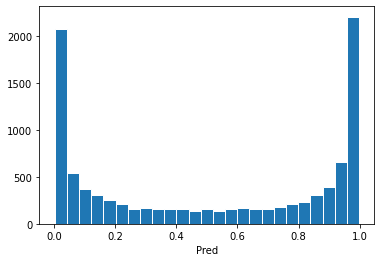

In [46]:
plt.hist(submit_810.label,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

In [47]:
#train,testでダブっているデータを参照
dup_test_ids = ['test_01704','test_03707','test_04353','test_04453','test_04645','test_06909','test_08232']
sub_dup_810= submit_810[submit_810["id"].isin(dup_test_ids)]

T = pd.DataFrame([['train_00365','train_01463','train_02156','train_04506','train_06891','train_08302','train_09470'],
                [0,1,1,1,1,1,0],
                ['test_08232','test_01704','test_06909','test_04453','test_03707','test_04353','test_04645']]).T
T.columns =["train id","true label","id"]
T = T.sort_values(by="id")
T = T.merge(sub_dup_810,how='left',on='id')
T

,train id,true label,id,state,label
0,train_01463,1,test_01704,1,0.995038
1,train_06891,1,test_03707,1,0.991033
2,train_08302,1,test_04353,1,0.925482
3,train_04506,1,test_04453,1,0.997079
4,train_09470,0,test_04645,0,0.193316
5,train_02156,1,test_06909,1,0.696601
6,train_00365,0,test_08232,0,0.189196


In [ ]:
"""
#0.8319903303787268
predictions_805_2 = predictions_19*0.08771571 + predictions_20*0.05629589 + predictions_22*0.01652287 + predictions_23*0.02771205 + predictions_24*0.01048438 + predictions_27*0.11410127 + predictions_31*0.04871708 + predictions_42*0.11278922 + predictions_21*0.04335175 + predictions_43*0.10829126 + predictions_44*0.10222701 + predictions_45*0.03187614 + predictions_34*0.07385553 + predictions_39*0.10005615 + predictions_47*0.0199686 + predictions_48*0.04603509

submit_805_2 = sub.copy()
#submit.columns = ["id","label"]

submit_805_2['label'] = predictions_805_2
submit_805_2['state'] = (predictions_805_2>0.5).astype(int)

submit_805_2[["id","state"]].to_csv(os.path.join(OUTPUT_SUB_DIR,"more805_2_ensemble_submission8319.csv"),index=False,header=False)
display(submit_805_2)
"""

In [ ]:
#plt.hist(submit_805_2.label,bins=25,edgecolor='white')
#plt.xlabel("Pred")
#plt.show()

In [ ]:
"""
#train,testでダブっているデータを参照
dup_test_ids = ['test_01704','test_03707','test_04353','test_04453','test_04645','test_06909','test_08232']
sub_dup_805_2= submit_805_2[submit_805_2["id"].isin(dup_test_ids)]

T = pd.DataFrame([['train_00365','train_01463','train_02156','train_04506','train_06891','train_08302','train_09470'],
                [0,1,1,1,1,1,0],
                ['test_08232','test_01704','test_06909','test_04453','test_03707','test_04353','test_04645']]).T
T.columns =["train id","true label","id"]
T = T.sort_values(by="id")
T = T.merge(sub_dup_805_2,how='left',on='id')
T
"""